# Problem/need: Predicting whether a subject involved in a use of force incident will be injured or not

recall = tp/ap = tp/(tp+fn)

Since false negatives (predicting that use of force doesn't result in a subject being injured when it actually does) are more costly, I'm going to weight recall more heavily than precision by using F2 as my evaluation metric.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import statistics
import os

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score

import imblearn.over_sampling

In [2]:
os.getcwd()

'/Users/chloebergsma-safar/Desktop/Metis/NBM_Classification_Project/Metis-Classification'

In [3]:
os.chdir('/Users/chloebergsma-safar/Desktop/Metis/NBM_Classification_Project')

# Read in NYPD Use of Force datasets

## incidents

In [4]:
incidents = pd.read_csv('NYPD_Use_of_Force_Incidents.csv')

In [5]:
incidents.shape

(13527, 7)

In [6]:
incidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13527 entries, 0 to 13526
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   TRI Incident Number  13527 non-null  int64 
 1   ForceType            13527 non-null  object
 2   Occurrence Date      13527 non-null  object
 3   Incident Pct         13527 non-null  int64 
 4   Patrol Borough       13527 non-null  object
 5   YearMonthShort       13527 non-null  object
 6   BasisForEncounter    13527 non-null  object
dtypes: int64(2), object(5)
memory usage: 739.9+ KB


## members of service

In [7]:
members = pd.read_csv('NYPD_Use_of_Force__Members_of_Service.csv')

In [8]:
members.shape

(31257, 8)

In [9]:
members.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31257 entries, 0 to 31256
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   TRI Incident Number  31257 non-null  int64 
 1   ForceType            31257 non-null  object
 2   InjuryLevel          31257 non-null  object
 3   Member Injured       31257 non-null  object
 4   Rank Grouped         31257 non-null  object
 5   Assignment           31257 non-null  object
 6   Member Gender        31257 non-null  object
 7   Race                 31257 non-null  object
dtypes: int64(1), object(7)
memory usage: 1.9+ MB


## subjects

In [10]:
subjects = pd.read_csv('NYPD_Use_of_Force__Subjects.csv')

In [11]:
subjects.shape

(13283, 8)

In [12]:
subjects.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13283 entries, 0 to 13282
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TRI Incident Number   13283 non-null  int64  
 1   Subject Injury Level  13283 non-null  object 
 2   Subject Injured       13283 non-null  object 
 3   Age                   12741 non-null  float64
 4   Subject Race          13283 non-null  object 
 5   Subject Gender        13283 non-null  object 
 6   Force Against MOS     13283 non-null  object 
 7   Subject Used Force    13283 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 830.3+ KB


# Brielfy analyze individual datasets

## incidents

In [13]:
incidents.columns

Index(['TRI Incident Number', 'ForceType', 'Occurrence Date', 'Incident Pct',
       'Patrol Borough', 'YearMonthShort', 'BasisForEncounter'],
      dtype='object')

In [14]:
incidents['Occurrence Date'].value_counts()

06/01/2020    82
01/01/2020    69
06/02/2020    64
05/29/2020    63
05/31/2020    51
              ..
07/18/2020     4
07/17/2020     4
03/28/2021     4
07/16/2020     2
07/06/2020     1
Name: Occurrence Date, Length: 731, dtype: int64

In [15]:
incidents['ForceType'].value_counts()

Physical Force              10172
Electrical Weapon            2855
OC Spray                      259
Impact Weapon                 142
Firearm                        88
Restraining Mesh Blanket        8
Police Canine                   3
Name: ForceType, dtype: int64

In [16]:
incidents['BasisForEncounter'].value_counts()

CRIME/VIOLATION IN PROGRESS              5279
PERSON IN CRISIS                         3235
OTHER                                    1273
PRISONER                                 1092
CROWD CONTROL                             526
VTL INFRACTION                            441
WANTED SUSPECT (E.G. WARRANT, I CARD)     437
PAST CRIME/VIOLATION                      402
SUSPICIOUS ACTIVITY                       226
DETECTIVE INVESTIGATION                   140
TRANSIT EJECTION                          104
ORDER OF PROTECTION                        95
NON-CRIME CALLS FOR SERVICE                95
IN CUSTODY INJURY                          71
HOME VISIT                                 38
AMBUSH OF MEMBER                           23
SEARCH WARRANT                             23
ANIMAL CONDITION                           14
HOSTAGE/BARRICADED                         13
Name: BasisForEncounter, dtype: int64

## members

In [17]:
members.columns

Index(['TRI Incident Number', 'ForceType', 'InjuryLevel', 'Member Injured',
       'Rank Grouped', 'Assignment', 'Member Gender', 'Race'],
      dtype='object')

In [18]:
members['InjuryLevel'].value_counts()

No Injury                      25794
Physical Injury                 5062
Substantial Physical Injury      261
Serious Physical Injury          140
Name: InjuryLevel, dtype: int64

In [19]:
members['Rank Grouped'].value_counts()

Police Officer      26512
Sergeant             2353
Detective            1251
Lieutenant            718
Other                 290
Captain                71
Deputy Inspector       26
Inspector              15
Chief                  13
RECODE                  8
Name: Rank Grouped, dtype: int64

In [20]:
members['Assignment'].value_counts()

SECTOR/RESPONSE AUTO    19003
OTHER                    6168
FIXED POST               1919
ANTI-CRIME               1897
NCO                      1122
INVESTIGATION            1055
OFF DUTY                   71
SCOOTER                    22
Name: Assignment, dtype: int64

In [21]:
members['Member Gender'].value_counts()

MALE      27817
FEMALE     3440
Name: Member Gender, dtype: int64

In [22]:
members['Race'].value_counts()

WHITE          14767
HISPANIC       10001
BLACK           3775
ASIAN           2673
AMER INDIAN       25
OTH/UNK           16
Name: Race, dtype: int64

## subjects

In [23]:
subjects.columns

Index(['TRI Incident Number', 'Subject Injury Level', 'Subject Injured', 'Age',
       'Subject Race', 'Subject Gender', 'Force Against MOS',
       'Subject Used Force'],
      dtype='object')

In [24]:
subjects['Subject Injury Level'].value_counts()

No Injury                      8988
Physical Injury                4009
Substantial Physical Injury     151
Serious Physical Injury         115
Death                            20
Name: Subject Injury Level, dtype: int64

In [25]:
subjects['Force Against MOS'].value_counts()

Physical Force        11552
No Force               1434
Displayed Weapon        158
Impact Weapon           100
Firearm                  22
Cutting Instrument       17
Name: Force Against MOS, dtype: int64

In [26]:
subjects['Subject Race'].value_counts()

BLACK          7386
HISPANIC       3841
WHITE          1167
UNK/OTH         531
ASIAN           329
AMER INDIAN      29
Name: Subject Race, dtype: int64

# Feature Types

* **Incident** features: general information about ___all___ incidents involving NYPD use of force. Examples: the force type, when the incident occurred, incident precinct, the patrol borough, and the basis of encounter.
* **Subject** features: information about specific subjects involved in use of force incidents. Examples: age, race, whether subject used force against a member of service, type of force used against member of service. 
* **Member of Service** features: information about specific members of service involved in use of force incidents. Examples: force type, whether member of service was injured, injury level, ranking group, assignment, gender, race. 
* **Incident-Subject-Member of Service** features: information about specific incidents involving subjects and members of service. Examples: number of subjects involved in an incident, number of members of service involved in an incident.

# Clean individual datasets

In [27]:
# clean up column names in datasets

incidents.columns = incidents.columns.str.lower().str.replace(' ','_')
members.columns = members.columns.str.lower().str.replace(' ','_')
subjects.columns = subjects.columns.str.lower().str.replace(' ','_')

In [28]:
incidents['occurrence_date_rev'] = pd.to_datetime(incidents['occurrence_date'])

In [29]:
incidents['occurrence_date_rev'].min()

Timestamp('2020-01-01 00:00:00')

In [30]:
incidents['occurrence_date_rev'].max()

Timestamp('2021-12-31 00:00:00')

In [31]:
incidents['year'] = incidents['occurrence_date_rev'].dt.year
incidents['month'] = incidents['occurrence_date_rev'].dt.month

In [32]:
incidents.drop(['occurrence_date', 'yearmonthshort'],axis=1,inplace=True)

# Constructing the observations

Each observation = a subject-incident pair

In [33]:
# create df that only includes tri_incident_numbers in subjects dataset that are also in members dataset

members_tri_ids = members['tri_incident_number'].unique()
subjects_df = subjects[subjects['tri_incident_number'].isin(members_tri_ids)]

In [34]:
subjects.shape

(13283, 8)

In [35]:
subjects_df.shape

(13230, 8)

In [36]:
subjects_df['tri_incident_number'].nunique()

12589

In [37]:
subjects_df.columns

Index(['tri_incident_number', 'subject_injury_level', 'subject_injured', 'age',
       'subject_race', 'subject_gender', 'force_against_mos',
       'subject_used_force'],
      dtype='object')

In [38]:
# add column to assign index to each subject
subjects_df.reset_index(inplace=True)
subjects_df = subjects_df.rename(columns = {'index':'subject_id'})

In [39]:
subjects_df.head()

,subject_id,tri_incident_number,subject_injury_level,subject_injured,age,subject_race,subject_gender,force_against_mos,subject_used_force
0,0,2020020962054,No Injury,N,28.0,BLACK,MALE,Physical Force,Y
1,1,2020020962062,No Injury,N,28.0,BLACK,MALE,Physical Force,Y
2,2,2020024962101,No Injury,N,28.0,BLACK,MALE,Physical Force,Y
3,3,2020024962121,No Injury,N,28.0,BLACK,MALE,Physical Force,Y
4,4,2020028962025,No Injury,N,28.0,BLACK,MALE,Physical Force,Y


In [40]:
# create first feature variable -> whether subject used force or not against member of service (mos)

subjects_df = pd.get_dummies(subjects_df, columns=['subject_used_force'], drop_first=True)

In [41]:
# create df of tri_incident_number and first feature

df_X = subjects_df[['subject_id','tri_incident_number','subject_used_force_Y']]

In [42]:
df_X.shape

(13230, 3)

# Constructing the observations' target values

In [43]:
subjects_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13230 entries, 0 to 13229
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   subject_id            13230 non-null  int64  
 1   tri_incident_number   13230 non-null  int64  
 2   subject_injury_level  13230 non-null  object 
 3   subject_injured       13230 non-null  object 
 4   age                   12692 non-null  float64
 5   subject_race          13230 non-null  object 
 6   subject_gender        13230 non-null  object 
 7   force_against_mos     13230 non-null  object 
 8   subject_used_force_Y  13230 non-null  uint8  
dtypes: float64(1), int64(2), object(5), uint8(1)
memory usage: 839.9+ KB


In [44]:
subjects_df['subject_injured'].value_counts(normalize=True)

N    0.677249
Y    0.322751
Name: subject_injured, dtype: float64

In [45]:
# convert 'subject_injured' to 1s and 0s

subjects_df['subject_injured'] = subjects_df['subject_injured'].apply(lambda x: 1 if x == 'Y' else 0)

In [46]:
subjects_tri_injured = subjects_df[['subject_id','tri_incident_number','subject_injured']]

In [47]:
subjects_tri_injured.shape

(13230, 3)

In [48]:
# create target variable

df_X = df_X.merge(subjects_tri_injured, how='left',on='subject_id')

In [49]:
df_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13230 entries, 0 to 13229
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   subject_id             13230 non-null  int64
 1   tri_incident_number_x  13230 non-null  int64
 2   subject_used_force_Y   13230 non-null  uint8
 3   tri_incident_number_y  13230 non-null  int64
 4   subject_injured        13230 non-null  int64
dtypes: int64(4), uint8(1)
memory usage: 529.7 KB


In [50]:
df_X.drop(['tri_incident_number_y'],axis=1,inplace=True)

In [51]:
df_X.rename(columns={"tri_incident_number_x": "tri_incident_number"}, inplace=True)

# EDA and Baselining

0    0.677249
1    0.322751
Name: subject_injured, dtype: float64


<AxesSubplot:>

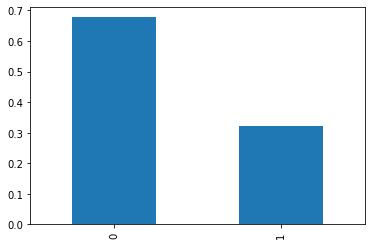

In [52]:
# check how imbalanced the target variable is

target_pcts = df_X.subject_injured.value_counts(normalize=True) 
print(target_pcts)

target_pcts.plot(kind='bar')

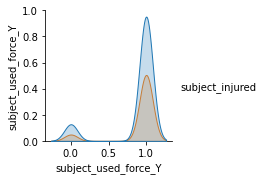

In [53]:
# create a helper function for plotting feature(s) vs target variable 

def plot_features(df, sample_size=500):
    
    sample = (df.sample(1000, random_state=44)) 
    sns.pairplot(sample,hue='subject_injured', plot_kws=dict(alpha=.3, edgecolor='none'))

plot_features(df_X[['subject_used_force_Y','subject_injured']])

In [54]:
X_1 = np.array(df_X['subject_used_force_Y']).reshape(-1,1)
y = np.array(df_X['subject_injured'])

In [55]:
y.shape

(13230,)

In [56]:
X_1.shape

(13230, 1)

In [57]:
# split data into training/validation and test data

X_tr_val, X_te, y_tr_val, y_te = train_test_split(X_1, y, test_size=0.2, random_state=42)

In [58]:
# simple logistic regression

lr = LogisticRegression(solver='lbfgs')
lr.fit(X_tr_val, y_tr_val)

kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_results = cross_validate(lr, X_tr_val, y_tr_val, cv=kf, scoring='recall')

y_pred = lr.predict(X_tr_val)

print(f"recall: {(cv_results['test_score'])}")
print("")
print(f"mean recall: {(np.mean(cv_results['test_score'])):.3f}")
print("")
print(f"f2 score: {fbeta_score(y_tr_val, y_pred, beta=2):.3f}")

recall: [0. 0. 0. 0. 0.]

mean recall: 0.000

f2 score: 0.000


# Feature engineering to improve the model

## Create second feature -> the type of force used by a member of service

In [84]:
incidents['forcetype'].value_counts()

KeyError: 'forcetype'

In [60]:
incidents = pd.get_dummies(incidents, columns=['forcetype'], drop_first=True)

In [61]:
df_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13230 entries, 0 to 13229
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   subject_id            13230 non-null  int64
 1   tri_incident_number   13230 non-null  int64
 2   subject_used_force_Y  13230 non-null  uint8
 3   subject_injured       13230 non-null  int64
dtypes: int64(3), uint8(1)
memory usage: 426.4 KB


In [62]:
incidents_tri_forcetype = incidents[['tri_incident_number','forcetype_Firearm','forcetype_Impact Weapon',
                                     'forcetype_OC Spray','forcetype_Physical Force','forcetype_Police Canine',
                                     'forcetype_Restraining Mesh Blanket']]

df_X = df_X.merge(incidents_tri_forcetype, on='tri_incident_number')

In [64]:
df_X.shape

(13230, 10)

## Second model

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


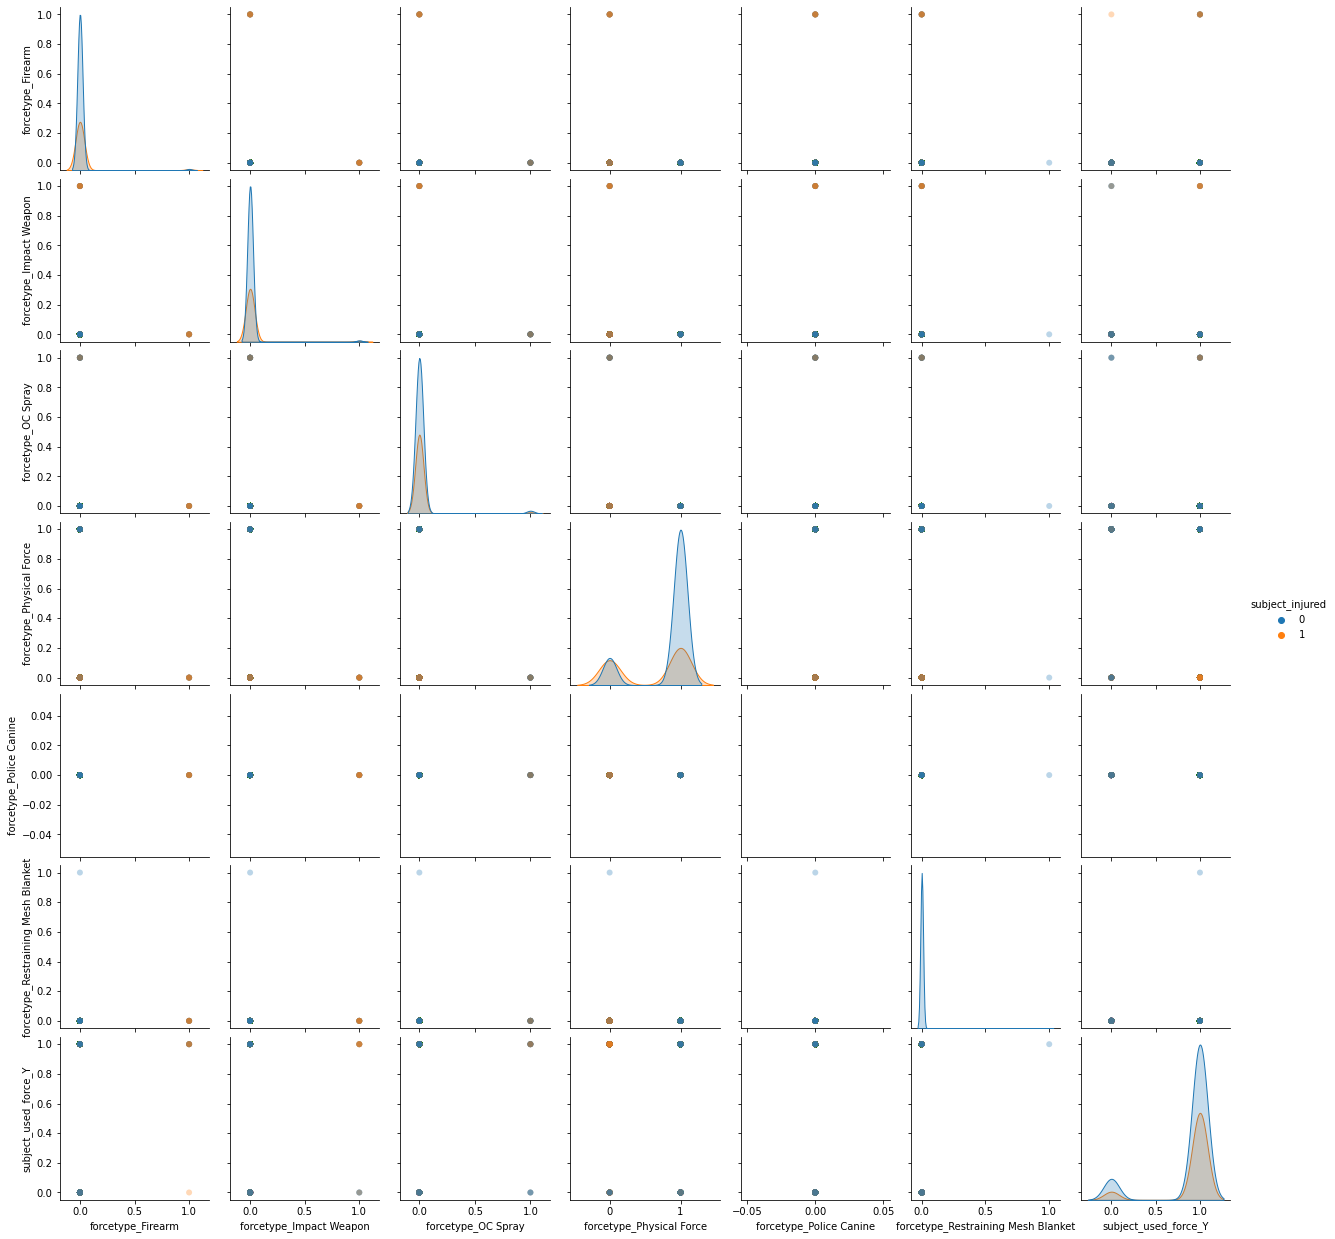

In [73]:
plot_features(df_X[['forcetype_Firearm','forcetype_Impact Weapon','forcetype_OC Spray','forcetype_Physical Force',
                    'forcetype_Police Canine','forcetype_Restraining Mesh Blanket','subject_used_force_Y',
                    'subject_injured']])

In [78]:
X_2 = np.array(df_X[['subject_used_force_Y','forcetype_Firearm','forcetype_Impact Weapon','forcetype_OC Spray',
                    'forcetype_Physical Force','forcetype_Police Canine',
                    'forcetype_Restraining Mesh Blanket']])

In [80]:
# split data into training/validation and test data

X_tr_val_2, X_te_2, y_tr_val_2, y_te_2 = train_test_split(X_2, y, test_size=0.2, random_state=42)

In [91]:
# logistic regression with two features

lr_2 = LogisticRegression(solver='lbfgs')
lr_2.fit(X_tr_val_2, y_tr_val_2)

kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_results = cross_validate(lr_2, X_tr_val_2, y_tr_val_2, cv=kf, scoring='recall')

y_pred_2 = lr_2.predict(X_tr_val_2)

print(f"recall: {(cv_results['test_score'])}")
print("")
print(f"mean recall: {(np.mean(cv_results['test_score'])):.3f}")
print("")
print(f"f2 score: {fbeta_score(y_tr_val_2, y_pred_2, beta=2):.3f}")

recall: [0.35460993 0.38880249 0.33773862 0.36402878 0.35312024]

mean recall: 0.360

f2 score: 0.390


## Create third feature -> the type of force used by a member of service

In [97]:
incidents.columns

Index(['tri_incident_number', 'incident_pct', 'patrol_borough',
       'basisforencounter', 'occurrence_date_rev', 'year', 'month',
       'forcetype_Firearm', 'forcetype_Impact Weapon', 'forcetype_OC Spray',
       'forcetype_Physical Force', 'forcetype_Police Canine',
       'forcetype_Restraining Mesh Blanket'],
      dtype='object')

In [96]:
incidents['incident_pct'].nunique()

77

In [98]:
incidents['basisforencounter'].nunique()

19

In [92]:
df_X.columns

Index(['subject_id', 'tri_incident_number', 'subject_used_force_Y',
       'subject_injured', 'forcetype_Firearm', 'forcetype_Impact Weapon',
       'forcetype_OC Spray', 'forcetype_Physical Force',
       'forcetype_Police Canine', 'forcetype_Restraining Mesh Blanket'],
      dtype='object')

In [93]:
# get ratio of features to rows
(df_X.shape[1]-3)/len(df_X)

0.0005291005291005291

In [65]:
# logistic regression with over-sampling

# setup for the ratio argument of RandomOverSampler initialization
#n_pos = np.sum(y_tr_val == 1)
#n_neg = np.sum(y_tr_val == 0)
#ratio = {1 : n_pos * 2, 0 : n_neg} 

# randomly oversample positive samples: create 10x as many 
#ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 
    
#X_tr_val_rs, y_tr_val_rs = ROS.fit_resample(X_tr_val, y_tr_val)

#lr_os = LogisticRegression(solver='lbfgs')
#lr_os.fit(X_tr_val_rs, y_tr_val_rs)

#kf = KFold(n_splits=5, shuffle=True, random_state = 71)
#cv_results = cross_validate(lr_os, X_tr_val_rs, y_tr_val_rs, cv=kf, scoring='recall')

#y_pred = lr_os.predict(X_tr_val)

#print(f"recall: {(cv_results['test_score'])}")
#print("")
#print(f"mean recall: {(np.mean(cv_results['test_score'])):.3f}")
#print("")
#print(f"f2 score: {fbeta_score(y_tr_val, y_pred, beta=2):.3f}")

In [66]:
#incidents_members = incidents.merge(members,how='left',on='TRI Incident Number')

In [67]:
#incidents_members.shape

In [68]:
#df_merged = incidents.merge(members,how='left',on='TRI Incident Number').merge(subjects, how='left', on='TRI Incident Number')

In [69]:
#df_merged.shape

In [70]:
#df_merged.columns

In [71]:
#df_merged['TRI Incident Number'].nunique()